# CausalLift demo


### Please see the GitHub repository for details about CausalLift package: 

https://github.com/Minyus/causallift

## Import CausalLift

In [1]:
try: 
    import causallift
except:
    """ Install CausalLift """
    !pip3 install causallift
    
    """  Alternatively, you can install the pre-release build by: """ 
    # !pip3 install git+git://github.com/Minyus/causallift@v1.0
    
    """  Alternatively, you can import from the cloned GitHub repository without installing: """ 
    # import sys
    # from pathlib import Path
    # print('Current Working Directory: {}'.format(Path().cwd()))
    # sys.path.insert(0, str(Path().cwd().parent.parent / "src"))

In [2]:
import causallift
causallift.__version__

'1.0.3'

In [3]:
from causallift import CausalLift

## Import other modules

In [4]:
from sklearn.model_selection import train_test_split

import pandas as pd

""" display only top 4 and bottom 4 rows of pandas Data Frame if more than 8 rows """
pd.options.display.max_rows = 8 

seed = 0

## Prepare data

In [5]:
data = 'simulated_observational_data'
# data = 'lalonde'

if data == 'simulated_observational_data':
    """
    # Generate simulated data
    # "Sleeping dogs" (a.k.a. "do-not-disturb"; people who will "buy" if not 
    treated but will not "buy" if treated) can be simulated by negative values 
    in tau parameter.
    # Observational data which includes confounding can be simulated by 
    non-zero values in propensity_coef parameter.  
    # A/B Test (RCT) with a 50:50 split can be simulated by all-zeros values 
    in propensity_coef parameter (default).
    # The first element in each list parameter specifies the intercept.
    """
    from causallift import generate_data

    df = generate_data( \
        N=1000, 
        n_features=3, 
        beta=[0,-2,3,-5], # Effect of [intercept and features] on outcome 
        error_std=0.1, 
        tau=[1,-5,-5,10], # Effect of [intercept and features] on treated outcome
        tau_std=0.1, 
        discrete_outcome=True, 
        seed=seed, 
        feature_effect=0, # Effect of beta on treated outxome
        propensity_coef=[0,-1,1,-1], # Effect of [intercept and features] on propensity log-odds for treatment
        index_name='index')
    
if data == 'lalonde':
    r""" 
        Lalonde dataset was used to evaluate propensity score in the paper:
        Dehejia, R., & Wahba, S. (1999). Causal Effects in Nonexperimental 
        Studies: Reevaluating the Evaluation of Training Programs. Journal of 
        the American Statistical Association, 94(448), 1053-1062. 
        doi:10.2307/2669919

        Lalonde dataset is now included in R package named "Matching."
        http://sekhon.berkeley.edu/matching/lalonde.html
    """
    import numpy as np
    
    def get_lalonde():
        r""" Load datasets, concatenate, and create features to get data frame 
        similar to 'lalonde' that comes with "Matching.")
        """
        cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
        control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep='\s+', header = None, names = cols)
        treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep='\s+', header = None, names = cols)
        lalonde_df = pd.concat([control_df, treated_df], ignore_index=True)
        lalonde_df['u74'] = np.where(lalonde_df['re74'] == 0, 1.0, 0.0)
        lalonde_df['u75'] = np.where(lalonde_df['re75'] == 0, 1.0, 0.0)
        return lalonde_df
    lalonde_df = get_lalonde()
    
    """ Prepare the input Data Frame. """
    df = lalonde_df.copy()
    df.rename(columns={'treat':'Treatment', 're78':'Outcome'}, inplace=True)
    df['Outcome'] = np.where(df['Outcome'] > 0, 1.0, 0.0)
    
    # categorize age to 20s, 30s, 40s, and 50s and then one-hot encode age
    df.loc[:,'age'] = df['age'].apply(lambda x:'{:.0f}'.format(x)[:-1]+'0s') 
    df = pd.get_dummies(df, columns=['age'], drop_first=True) 
    
    cols = ['nodegr', 'black', 'hisp', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 
            'educ', 'married', 'u74', 'u75', 'Treatment', 'Outcome']
    df = df[cols]
    
    

In [6]:
df

,Feature_0,Feature_1,Feature_2,Treatment,Outcome
index,,,,,
0,0.548814,0.715189,0.602763,1.0,0.0
1,0.544883,0.423655,0.645894,0.0,0.0
2,0.437587,0.891773,0.963663,0.0,0.0
3,0.383442,0.791725,0.528895,0.0,0.0
...,...,...,...,...,...
996,0.774353,0.560374,0.082494,0.0,0.0
997,0.475214,0.287293,0.879682,0.0,0.0
998,0.284927,0.941687,0.546133,1.0,0.0
999,0.323614,0.813545,0.697400,1.0,1.0


## EDA

In [7]:
df

,Feature_0,Feature_1,Feature_2,Treatment,Outcome
index,,,,,
0,0.548814,0.715189,0.602763,1.0,0.0
1,0.544883,0.423655,0.645894,0.0,0.0
2,0.437587,0.891773,0.963663,0.0,0.0
3,0.383442,0.791725,0.528895,0.0,0.0
...,...,...,...,...,...
996,0.774353,0.560374,0.082494,0.0,0.0
997,0.475214,0.287293,0.879682,0.0,0.0
998,0.284927,0.941687,0.546133,1.0,0.0
999,0.323614,0.813545,0.697400,1.0,1.0


In [8]:
pd.crosstab(df['Outcome'], df['Treatment'], margins = True)

Treatment,0.0,1.0,All
Outcome,,,
0.0,575,236,811
1.0,48,141,189
All,623,377,1000


In [9]:
df.describe()

,Feature_0,Feature_1,Feature_2,Treatment,Outcome
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.505377,0.498557,0.508785,0.377000,0.189000
std,0.298402,0.291584,0.286888,0.484877,0.391705
min,0.000074,0.000367,0.000546,0.000000,0.000000
25%,0.245889,0.259544,0.274155,0.000000,0.000000
50%,0.504705,0.498307,0.499050,0.000000,0.000000
75%,0.770974,0.756424,0.755279,1.000000,0.000000
max,0.998355,0.999964,0.999809,1.000000,1.000000


In [10]:
df.corr()

,Feature_0,Feature_1,Feature_2,Treatment,Outcome
Feature_0,1.000000,0.015490,0.066867,-0.168785,-0.422922
Feature_1,0.015490,1.000000,0.030081,0.142777,0.052125
Feature_2,0.066867,0.030081,1.000000,-0.210067,-0.045110
Treatment,-0.168785,0.142777,-0.210067,1.000000,0.367595
Outcome,-0.422922,0.052125,-0.045110,0.367595,1.000000


## Split to train and test

In [11]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['Treatment'])

## Run Uplift modeling


[Estimate propensity scores for Inverse Probability Weighting.]
[2020-04-04 01:12:32,934|causallift.context.flexible_context|INFO] Run pipeline (tags: ['011_bundle_train_and_test_data'], SequentialRunner, only_missing: False)
[2020-04-04 01:12:32,950|kedro.pipeline.node|INFO] Running node: bundle_train_and_test_data([args_raw,test_df,train_df]) -> [df_00]
[2020-04-04 01:12:32,956|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-04-04 01:12:32,958|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-04-04 01:12:32,960|causallift.context.flexible_context|INFO] Run pipeline (tags: ['121_prepare_args', '131_treatment_fractions_', '141_initialize_model'], SequentialRunner, only_missing: False)
[2020-04-04 01:12:32,973|kedro.pipeline.node|INFO] Running node: impute_cols_features([args_raw,df_00]) -> [args_intermediate]
[2020-04-04 01:12:32,975|kedro.runner.sequential_runner|INFO] Completed 1 out of 3 tasks
[2020-04-04 01:12:32,978|kedro.

,Feature_0,Feature_1,Feature_2
coefficient,-1.014672,1.245857,-1.43388


[2020-04-04 01:12:34,267|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-04-04 01:12:34,274|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-04-04 01:12:34,281|causallift.context.flexible_context|INFO] Run pipeline (tags: ['221_estimate_propensity'], SequentialRunner, only_missing: False)
[2020-04-04 01:12:34,303|kedro.pipeline.node|INFO] Running node: estimate_propensity([args,df_00,propensity_model]) -> [df_01]
[2020-04-04 01:12:34,321|causallift.nodes.estimate_propensity|INFO] 
### Histogram of propensity score for train and test data:


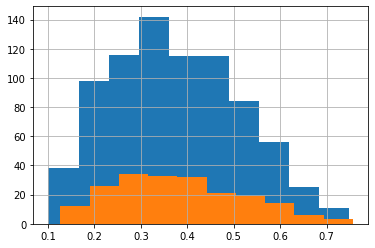

[2020-04-04 01:12:34,661|causallift.nodes.estimate_propensity|INFO] 
### Score Table for logistic regression to calculate propensity score:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,800,2,0.65875,0.591195,0.311258,0.407809,0.590368,0.3775,0.19875
test,200,2,0.70000,0.674419,0.386667,0.491525,0.637333,0.3750,0.21500


[2020-04-04 01:12:34,696|causallift.nodes.estimate_propensity|INFO] 
### Confusion Matrix for Train:


,Pred_0,Pred_1
True_0,433,65
True_1,208,94


[2020-04-04 01:12:34,707|causallift.nodes.estimate_propensity|INFO] 
### Confusion Matrix for Test:


,Pred_0,Pred_1
True_0,111,14
True_1,46,29


[2020-04-04 01:12:34,724|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-04-04 01:12:34,727|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-04-04 01:12:34,732|causallift.causal_lift|INFO] ### Treatment fraction in train dataset: 0.3775
[2020-04-04 01:12:34,735|causallift.causal_lift|INFO] ### Treatment fraction in test dataset: 0.375


In [12]:
print('\n[Estimate propensity scores for Inverse Probability Weighting.]')
cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

In [13]:
print('\n[Create 2 models for treatment and untreatment and estimate CATE (Conditional Average Treatment Effects)]')
train_df, test_df = cl.estimate_cate_by_2_models()

print('\n[Show CATE for train dataset]')
display(train_df)
train_df.to_csv('CATE_for_Train.csv')

print('\n[Show CATE for test dataset]')
display(test_df)
test_df.to_csv('CATE_for_Test.csv')


[Create 2 models for treatment and untreatment and estimate CATE (Conditional Average Treatment Effects)]
[2020-04-04 01:12:34,789|causallift.context.flexible_context|INFO] Run pipeline (tags: ['311_fit', '312_bundle_2_models'], SequentialRunner, only_missing: False)
[2020-04-04 01:12:34,811|kedro.pipeline.node|INFO] Running node: model_for_untreated_fit([args,df_01]) -> [untreated__model_dict]
[2020-04-04 01:12:34,813|causallift.nodes.model_for_each|INFO] 

## Model for Treatment = 0.0
[2020-04-04 01:12:35,620|causallift.nodes.model_for_each|INFO] ### Best parameters of the model trained using samples with observational Treatment: 0.0 
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'monotone_constraints': N

,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,498,2,1.000,1.0,1.00,1.000000,1.000,0.072289,0.072289
test,125,2,0.976,1.0,0.75,0.857143,0.875,0.096000,0.072000


[2020-04-04 01:12:35,664|kedro.runner.sequential_runner|INFO] Completed 1 out of 3 tasks
[2020-04-04 01:12:35,667|kedro.pipeline.node|INFO] Running node: model_for_treated_fit([args,df_01]) -> [treated__model_dict]
[2020-04-04 01:12:35,670|causallift.nodes.model_for_each|INFO] 

## Model for Treatment = 1.0
[2020-04-04 01:12:36,099|causallift.nodes.model_for_each|INFO] ### Best parameters of the model trained using samples with observational Treatment: 1.0 
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': None, 'validat

,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,302,2,1.000000,1.0,1.000000,1.000000,1.000000,0.364238,0.364238
test,75,2,0.973333,1.0,0.935484,0.966667,0.967742,0.413333,0.386667


[2020-04-04 01:12:36,140|kedro.runner.sequential_runner|INFO] Completed 2 out of 3 tasks
[2020-04-04 01:12:36,155|kedro.pipeline.node|INFO] Running node: bundle_treated_and_untreated_models([treated__model_dict,untreated__model_dict]) -> [uplift_models_dict]
[2020-04-04 01:12:36,167|kedro.runner.sequential_runner|INFO] Completed 3 out of 3 tasks
[2020-04-04 01:12:36,172|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-04-04 01:12:36,206|causallift.context.flexible_context|INFO] Run pipeline (tags: ['321_predict_proba'], SequentialRunner, only_missing: False)
[2020-04-04 01:12:36,235|kedro.pipeline.node|INFO] Running node: model_for_untreated_predict_proba([args,df_01,uplift_models_dict]) -> [untreated__proba]
[2020-04-04 01:12:36,254|kedro.runner.sequential_runner|INFO] Completed 1 out of 2 tasks
[2020-04-04 01:12:36,272|kedro.pipeline.node|INFO] Running node: model_for_treated_predict_proba([args,df_01,uplift_models_dict]) -> [treated__proba]
[2020

,Feature_0,Feature_1,Feature_2,Treatment,Outcome,Propensity,Proba_if_Treated,Proba_if_Untreated,CATE
index,,,,,,,,,
0,0.027653,0.660339,0.414439,1.0,1.0,0.568200,0.993008,0.013552,0.979456
1,0.389549,0.263768,0.944626,0.0,0.0,0.206363,0.998338,0.000238,0.998100
2,0.023237,0.531104,0.204781,0.0,1.0,0.603150,0.918808,0.936053,-0.017245
3,0.110477,0.405036,0.405374,1.0,1.0,0.471381,0.999472,0.002058,0.997414
...,...,...,...,...,...,...,...,...,...
796,0.584645,0.091271,0.600471,0.0,0.0,0.219878,0.524303,0.000231,0.524071
797,0.493945,0.929619,0.667215,1.0,0.0,0.443840,0.039333,0.002723,0.036610
798,0.356007,0.987435,0.013655,1.0,0.0,0.715760,0.000503,0.998913,-0.998410
799,0.980486,0.096451,0.863471,0.0,0.0,0.115201,0.502907,0.000224,0.502684



[Show CATE for test dataset]


,Feature_0,Feature_1,Feature_2,Treatment,Outcome,Propensity,Proba_if_Treated,Proba_if_Untreated,CATE
index,,,,,,,,,
0,0.083165,0.974774,0.049285,0.0,1.0,0.756486,0.046007,0.999310,-0.953304
1,0.599581,0.430181,0.909093,0.0,0.0,0.213857,0.503638,0.000231,0.503406
2,0.653421,0.726342,0.536923,1.0,0.0,0.388449,0.000438,0.000399,0.000039
3,0.099733,0.475589,0.820022,0.0,0.0,0.351978,0.999531,0.000494,0.999037
...,...,...,...,...,...,...,...,...,...
196,0.351035,0.800597,0.365044,1.0,0.0,0.547841,0.006308,0.133655,-0.127346
197,0.693592,0.673458,0.952937,0.0,0.0,0.239214,0.134354,0.000268,0.134086
198,0.117320,0.107004,0.589695,0.0,0.0,0.319266,0.999761,0.000378,0.999383
199,0.627735,0.401428,0.416692,0.0,0.0,0.340701,0.002515,0.000295,0.002220


In [14]:
print('\n[Estimate the effect of recommendation based on the uplift model]')
estimated_effect_df = cl.estimate_recommendation_impact()

print('\n[Show the estimated effect of recommendation based on the uplift model]')
display(estimated_effect_df)


[Estimate the effect of recommendation based on the uplift model]
[2020-04-04 01:12:36,568|causallift.context.flexible_context|INFO] Run pipeline (tags: ['511_recommend_by_cate'], SequentialRunner, only_missing: False)
[2020-04-04 01:12:36,597|kedro.pipeline.node|INFO] Running node: recommend_by_cate([args,df_02,treatment_fractions]) -> [df_03]
[2020-04-04 01:12:36,704|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-04-04 01:12:36,711|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-04-04 01:12:36,752|causallift.context.flexible_context|INFO] Run pipeline (tags: ['521_simulate_recommendation'], SequentialRunner, only_missing: False)
[2020-04-04 01:12:36,813|kedro.pipeline.node|INFO] Running node: model_for_untreated_simulate_recommendation([args,df_03,uplift_models_dict]) -> [untreated__sim_eval_df]
[2020-04-04 01:12:36,868|causallift.nodes.model_for_each|INFO] 
### Simulated outcome of samples recommended to be treatment: 0.0

,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,498,2,0.919679,0.52381,1.000000,0.687500,0.955947,0.088353,0.168675
test,125,2,0.880000,0.50000,0.666667,0.571429,0.787879,0.120000,0.160000


[2020-04-04 01:12:36,910|kedro.runner.sequential_runner|INFO] Completed 1 out of 2 tasks
[2020-04-04 01:12:36,952|kedro.pipeline.node|INFO] Running node: model_for_treated_simulate_recommendation([args,df_03,uplift_models_dict]) -> [treated__sim_eval_df]
[2020-04-04 01:12:37,002|causallift.nodes.model_for_each|INFO] 
### Simulated outcome of samples recommended to be treatment: 1.0 by the uplift model:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,302,2,0.380795,0.352941,1.0,0.521739,0.5325,0.337748,0.956954
test,75,2,0.373333,0.373333,1.0,0.543689,0.5000,0.373333,1.000000


[2020-04-04 01:12:37,050|kedro.runner.sequential_runner|INFO] Completed 2 out of 2 tasks
[2020-04-04 01:12:37,053|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-04-04 01:12:37,076|causallift.context.flexible_context|INFO] Run pipeline (tags: ['531_estimate_effect'], SequentialRunner, only_missing: False)
[2020-04-04 01:12:37,113|kedro.pipeline.node|INFO] Running node: estimate_effect([treated__sim_eval_df,untreated__sim_eval_df]) -> [estimated_effect_df]
[2020-04-04 01:12:37,137|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-04-04 01:12:37,146|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-04-04 01:12:37,163|causallift.causal_lift|INFO] 
### Treated samples without and with uplift model:


,# samples chosen without uplift model,observed conversion rate without uplift model,# samples recommended by uplift model,predicted conversion rate using uplift model,predicted improvement rate
partition,,,,,
train,302,0.364238,302,0.956954,2.627273
test,75,0.413333,75,1.000000,2.419355


[2020-04-04 01:12:37,180|causallift.causal_lift|INFO] 
### Untreated samples without and with uplift model:


,# samples chosen without uplift model,observed conversion rate without uplift model,# samples recommended by uplift model,predicted conversion rate using uplift model,predicted improvement rate
partition,,,,,
train,498,0.072289,498,0.168675,2.333333
test,125,0.096000,125,0.160000,1.666667



[Show the estimated effect of recommendation based on the uplift model]


,# samples,observed conversion rate without uplift model,predicted conversion rate using uplift model,predicted improvement rate
partition,,,,
train,800,0.1825,0.46625,2.554795
test,200,0.2150,0.47500,2.209302


Targeting based on recommendation by uplift model is predicted to increase the conversion rate by 2.209 times (0.215 to 0.475) on the test portion of simulated observational data!